# ECE324 Mini-Project 2

Amy Chen, 1005915495

In [ ]:
# Import
import pandas as pd
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

## Recall@K
The following function is used to calculate the Recall@K averaged across users for Parts 1 and 2. 

In [ ]:
# Function for Recall at k

def recallAtK(k, embedding, Adj_mat, n_users, n_movies):
    """
    Calculate Recall@k 

    Inputs:
    - k - value of k for Recall@k
    - embedding - learned embeddings of the nodes
    - Adj_mat - the adjacency matrix
    - n_users - number of users
    - n_movies - number of movies

    Outputs:
    - The average recall@k
    """

    recallAtk_vals = []
    
    n = n_users + n_movies
    movie_idxs = [i for i in range(n_users,n)]
    movie_embeddings = embedding(torch.tensor(movie_idxs))
    
    for u in range(n_users):
        
        user_embeddings = embedding(torch.tensor(u))
        results = torch.matmul(user_embeddings, torch.t(movie_embeddings))
        
        # Ru
        rec_items = np.argpartition(results.detach().numpy(), -k)[-k:]

        # Pu
        pos_items = np.where(Adj_mat[u,:]==1)[0]

        # Pu \intersect Ru
        pos_and_rec_items = np.intersect1d(rec_items, pos_items)

        # Calculate |Pu \intersect Ru| / |Pu| for each user u
        if len(pos_items) > 0:
            recall = len(pos_and_rec_items)/len(pos_items)
            recallAtk_vals.append(recall)
        else:
            recall = 0
        #print(len(pos_and_rec_items), len(pos_items), recall)

    return np.mean(recallAtk_vals)

## Part 1: Directly Learning Embeddings
In this part, we directly learn the embeddings based on the function provided (see Equation 1).

### Data Preprocessing
The data is loaded into a panadas dataframe and each of the unique movies and users are re-indexed starting from 0. The data is then split into a 90% training dataset and a 10% testing dataset based on the timestamp (the newest timestamped data are used for testing). As well, the adjacency matrix for the training and testing data is created where an edge is created only when the user gives the movie a 5.0 rating.

In [ ]:
# Load Data
ratings = pd.read_csv("http://www.cs.toronto.edu/~guerzhoy/324/movielens/ratings.csv")
#ratings.head()

In [ ]:
n_movies = len(ratings['movieId'].unique())
n_users = len(ratings['userId'].unique())

In [ ]:
# Re-index movies
data2movieIdxs = {}
movieIdxs2data = {}
i = 0
for dataIdx in sorted(ratings['movieId'].unique()):
  data2movieIdxs[dataIdx] = i
  movieIdxs2data[i] = dataIdx
  i += 1

ratings['movieId'].replace(data2movieIdxs, inplace=True)

# Re-index users
data2userIdxs = {}
userIdxs2data = {}
i = 0
for dataIdx in sorted(ratings['userId'].unique()):
  data2userIdxs[dataIdx] = i
  userIdxs2data[i] = dataIdx
  i += 1

ratings['userId'].replace(data2userIdxs, inplace=True)

In [ ]:
# Split into Training and Testing sets by timestamp
N = len(ratings)
N_train = int(N*0.9)
N_test = N - N_train

ratings.sort_values(by=['timestamp'])
ratings_train = ratings.head(N_train)
ratings_test = ratings.tail(N_test)

assert(len(ratings_train) + len(ratings_test) == N)

In [ ]:
# Get adjacency matrix for training
adjacency_mat_train = np.zeros(shape=(n_users,n_movies))
for row in ratings_train.itertuples():
    userId = row[1]
    movieId = row[2]
    rating = row[3]
    if rating == 5.0:
        adjacency_mat_train[userId,movieId] = 1
#print(adjacency_mat_train)

# Get adjacency matrix for testing
adjacency_mat_test = np.zeros(shape=(n_users,n_movies))
for row in ratings_train.itertuples():
    userId = row[1]
    movieId = row[2]
    rating = row[3]
    if rating == 5.0:
        adjacency_mat_test[userId,movieId] = 1
#print(adjacency_mat_test)

### Learning the Embeddings
The embeddings are initialized such that the embedding for each user and movie is a size of 10. Training is done for a total of 20 epochs using the SGD optimizer with a learning rate of 0.001.

In [ ]:
# Parameters
learningRate = 0.001
numEpochs = 20

# Initialize Embeddings
n = n_users + n_movies
d = 10
embedding = nn.Embedding(n, d, max_norm=0.5) 

# SGD optimizer
optimizer = torch.optim.SGD(embedding.parameters(), lr=learningRate)

To directly learn the embeddings, we want to maximize Equation 1 below:
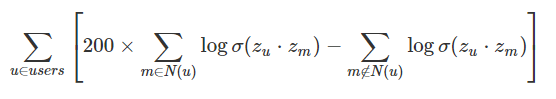

Therefore in our training loop, we calculate the negative of the above function as our loss and optimize based on that.

Epoch 0001  Training Loss -2397192.2500  Recall at 150 0.0114
Epoch 0002  Training Loss -2440352.5000  Recall at 150 0.0369
Epoch 0003  Training Loss -2479457.2500  Recall at 150 0.0909
Epoch 0004  Training Loss -2532858.5000  Recall at 150 0.2135
Epoch 0005  Training Loss -2609016.2500  Recall at 150 0.4522
Epoch 0006  Training Loss -2718285.7500  Recall at 150 0.5941
Epoch 0007  Training Loss -2849215.5000  Recall at 150 0.5567
Epoch 0008  Training Loss -2966731.5000  Recall at 150 0.5377
Epoch 0009  Training Loss -3054100.2500  Recall at 150 0.5233
Epoch 0010  Training Loss -3112884.7500  Recall at 150 0.5224
Epoch 0011  Training Loss -3150344.0000  Recall at 150 0.5201
Epoch 0012  Training Loss -3173689.7500  Recall at 150 0.5165
Epoch 0013  Training Loss -3188155.2500  Recall at 150 0.5136
Epoch 0014  Training Loss -3197116.0000  Recall at 150 0.5115
Epoch 0015  Training Loss -3202723.5000  Recall at 150 0.5100
Epoch 0016  Training Loss -3206301.2500  Recall at 150 0.5067
Epoch 00

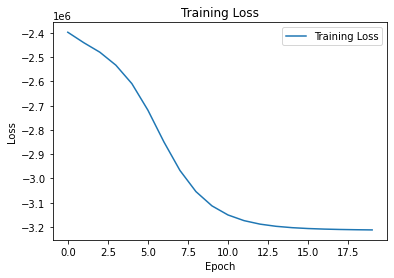

In [ ]:
# Training Loop
train_losses = []
for i in range(numEpochs):
    
    optimizer.zero_grad()
    max_func = 0 # Initialize function we want to maximize
    
    # Loop through users
    for u in range(n_users):

        # Get the embedding indices of the movies that are in N(u) 
        pos_movie_idxs = np.where(adjacency_mat_train[u,:]==1)[0]
        pos_movie_idxs = pos_movie_idxs + n_users

        # Get the embedding indices of the movies that are not in N(u) 
        neg_movie_idxs = np.where(adjacency_mat_train[u,:]!=1)[0]
        neg_movie_idxs = neg_movie_idxs + n_users
        
        # Get the embeddings 
        z_u = embedding(torch.tensor(u)) # embedding for z_u
        z_pos_m = embedding(torch.tensor(pos_movie_idxs)) # embedding for z_m's for m in N(u)
        z_neg_m = embedding(torch.tensor(neg_movie_idxs)) # embedding for z_m's for m not in N(u)
        
        # Calculate the value in the square brackets [*] from Equation 1 
        max_func_u = 200 * torch.sum(torch.log(torch.sigmoid(torch.matmul(z_u, torch.t(z_pos_m))))) - torch.sum(
            torch.log(torch.sigmoid(torch.matmul(z_u, torch.t(z_neg_m)))))

        # Update the value of the function
        max_func += max_func_u

    # Calculate loss as the negative of Equation 1
    loss = - max_func
    train_losses.append(loss.detach().numpy())

    # Calculate Recall@150 based on the training set
    recallAt150 = recallAtK(k=150, embedding=embedding, Adj_mat=adjacency_mat_train, n_users=n_users, n_movies=n_movies)
    
    # Optimize
    loss.backward()
    optimizer.step()

    # Print results for the epoch
    print('Epoch %04d  Training Loss %.4f  Recall at 150 %.4f' % (i + 1, loss.detach().numpy(), recallAt150))

# Plot Training Loss 
plt.title("Training Loss")
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

### Test Results
The test set resulted in an average Recall@150 of 49.26%. 

In [ ]:
# Test Results
recallAt150 = recallAtK(k=150, embedding=embedding, Adj_mat=adjacency_mat_test, n_users=n_users, n_movies=n_movies)
print("Testing Recall at 150:", recallAt150)

Testing Recall at 150: 0.4926157884961942


## Part 2: Node2Vec

In this part, we implement the Node2Vec algorithm to learn the graph embeddings.

### Data Preprocessing

Similar to Part 1, the data is loaded into a panadas dataframe and each of the unique movies and users are re-indexed starting from 0. The data is then split into a 80% training dataset, 10% validation dataset, and a 10% testing dataset based on the timestamp (the newest timestamped data are used for testing). As well, the adjacency matrix for the training and testing data is created where an edge is created only when the user gives the movie a 5.0 rating. For the training set, a probability matrix is also created to be used for the negative sampling based on the degree of each node.

In [ ]:
# Load Data
ratings = pd.read_csv("http://www.cs.toronto.edu/~guerzhoy/324/movielens/ratings.csv")
#ratings.head()

In [ ]:
n_movies = len(ratings['movieId'].unique())
n_users = len(ratings['userId'].unique())

In [ ]:
# Re-index movies
data2movieIdxs = {}
movieIdxs2data = {}
i = 0
for dataIdx in sorted(ratings['movieId'].unique()):
  data2movieIdxs[dataIdx] = i
  movieIdxs2data[i] = dataIdx
  i += 1

ratings['movieId'].replace(data2movieIdxs, inplace=True)

# Re-index users
data2userIdxs = {}
userIdxs2data = {}
i = 0
for dataIdx in sorted(ratings['userId'].unique()):
  data2userIdxs[dataIdx] = i
  userIdxs2data[i] = dataIdx
  i += 1

ratings['userId'].replace(data2userIdxs, inplace=True)

In [ ]:
# Split data into training, validation, and testing sets by timestamp

N = len(ratings)
N_train = int(N*0.8)
N_valid = int(N*0.1)
N_test = N - N_train - N_valid

ratings.sort_values(by=['timestamp'])
ratings_train = ratings.head(N_train)
ratings = ratings.tail(N_valid + N_test)
ratings_valid = ratings.head(N_valid)
ratings_test = ratings.tail(N_test)

assert(len(ratings_train) + len(ratings_valid) + len(ratings_test) == N)

In [ ]:
# Get adjacency matrix for training
adjacency_mat_train = np.zeros(shape=(n_users+n_movies,n_movies+n_movies))
for row in ratings_train.itertuples():
    userId = row[1]
    movieId = row[2]
    rating = row[3]
    if rating == 5.0:
        adjacency_mat_train[userId,movieId+n_users] = 1
        adjacency_mat_train[movieId+n_users,userId] = 1

# Find number of degree for each node and calculate the probability they
# would be selected during negative sampling
P_train = np.sum(adjacency_mat_train, axis=1)
train_probs = P_train / np.sum(P_train)

In [ ]:
# Get adjacency matrix for validation
adjacency_mat_valid = np.zeros(shape=(n_users,n_movies))
for row in ratings_valid.itertuples():
    userId = row[1]
    movieId = row[2]
    rating = row[3]
    if rating == 5.0:
        adjacency_mat_valid[userId,movieId] = 1

# Get adjacency matrix for testing
adjacency_mat_test = np.zeros(shape=(n_users,n_movies))
for row in ratings_valid.itertuples():
    userId = row[1]
    movieId = row[2]
    rating = row[3]
    if rating == 5.0:
        adjacency_mat_test[userId,movieId] = 1

### Node2Vec Implementation

To learn the embeddings, a random walk for each node is performed and the loss is calculated using the equations in the lecture slides (https://www.cs.toronto.edu/~guerzhoy/324/lec/W07/GNN.pdf Slides 16&17). 

In [ ]:
# Function for Random walk
def random_walk(Adj_mat, walk_length, start_node, p, q):
    """
    Returns a random walk of length walk_length from the start_node 
    
    Inputs:
    - Adj_mat: adjacency matrix of size (n_users + n_movies, n_users + n_movies)
    - walk_length: length of the random walk
    - start_node: node that the random walk starts at
    - p: in-out parameter
    - q: return parameter

    Output:
    - walk: list of nodes in the random walk 
    """

    walk = [start_node]
    for i in range(walk_length):
        curr = walk[-1]
        
        # Get neighbors
        curr_neighbors = np.where(Adj_mat[curr,:]==1)[0]
        num_neighbors = len(curr_neighbors)
        
        if num_neighbors > 0:

            # If first node, just choose a random next node
            if len(walk) == 1:
                next = curr_neighbors[np.random.randint(num_neighbors)]

            # Otherwise we sample based on p and q
            else:
                prev = walk[-2]
                transition_probs = [1/p] + [1/q]*num_neighbors
                nodes = [prev]
                nodes.extend(curr_neighbors)
                next = np.random.choice(a=nodes, p=transition_probs/np.sum(transition_probs))
            
            walk.append(next)
        
        else:
            break

    return walk

In [ ]:
# Training loop definition
def train_node2vec(q, p, walk_length, num_epochs, k, learningRate, max_norm,
                   n_users, n_movies, d, adjacency_mat_train, train_probs):
    """
    Training loop for node2vec

    Inputs:
    - q - return parameter for random walk
    - p - in-out parameter for random walk
    - walk_length - length of the random walk
    - num_epochs - number of epochs for training
    - k - number of negative sampled nodes
    - learningRate - learning rate
    - max_norm - normalization maximum for embedding
    - n_users - number of users
    - n_movies - number of movies
    - d - embedding size
    - adjacency_mat_train - training adjacency matrix
    - train_probs - probabilities used for negative sampling of nodes
    
    Outputs:
    - embedding_node2vec - final embedding learned
    - train_losses[-1] - final training loss value
    - recallAt150 - final training recall@150 value
    """

    # Embedding
    n = n_users + n_movies
    embedding_node2vec = nn.Embedding(n, d, max_norm=max_norm)

    # Optimizer
    optimizer = torch.optim.SGD(embedding_node2vec.parameters(), lr=learningRate)

    train_losses = []
    for epoch in range(num_epochs):

        optimizer.zero_grad()

        # Initialize walks and loss
        train_walks = []
        train_loss = 0
        
        # Get random walks
        for u in range(n_users):
            train_walks.append(random_walk(adjacency_mat_train, walk_length, u, p, q))

        # Calculate loss
        for u in range(n_users):
            
            train_walk = train_walks[u]

            # Get z_u
            train_u = train_walk[0]
            train_z_u = embedding_node2vec(torch.tensor(train_u))

            # Negative sampling - Get sample k random nodes based on their degree
            # Note: we sample negatives from the entire set
            train_neg_sampling_res = 0
            for i in range(k):
                train_n_idx = np.where(np.random.multinomial(1, train_probs)==1)[0][0]
                train_z_n = embedding_node2vec(torch.tensor(train_n_idx))
                train_neg_sampling_res += torch.log(torch.sigmoid(torch.dot(train_z_u, train_z_n)))
            
            # Loop through nodes in the random walk and update the loss
            for j in range(1,len(train_walk)):
                # Get z_v
                train_v = train_walk[j]
                train_z_v = embedding_node2vec(torch.tensor(train_v))

                train_walk_res = torch.log(torch.sigmoid(torch.dot(train_z_u, train_z_v)))

                # Update loss
                train_loss -= (train_walk_res - train_neg_sampling_res)
        
        # Record results
        recallAt150 = recallAtK(k=150, embedding=embedding_node2vec, Adj_mat=adjacency_mat_train, n_users=n_users, n_movies=n_movies)
        train_losses.append(train_loss.detach().numpy())
        print('Epoch %04d  Training Loss %.4f  Training Recall@150 %.4f' % (epoch + 1, train_loss.detach().numpy(), recallAt150))

        # Optimize
        train_loss.backward()
        optimizer.step()

    # Plot Loss 
    plt.title("Training Loss")
    plt.plot(train_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    return (embedding_node2vec, train_losses[-1], recallAt150)

### Node2Vec Tuning
In several trials, hyperparameters such as q, p, and walk length for the random walk, the amount of nodes that were randomly sampled, the size of the embedding for each node, and the learning rate and number of epochs were tuned to achieve better Node2Vec performance. The Recall@150 value for the validation set was used to evaluate the result of the learned embedding.

#### Trial 1 - Initial Results

Epoch 0001  Training Loss -31448.7031  Training Recall@150 0.0124
Epoch 0002  Training Loss -31481.5664  Training Recall@150 0.0125
Epoch 0003  Training Loss -31444.5605  Training Recall@150 0.0130
Epoch 0004  Training Loss -31513.3027  Training Recall@150 0.0133
Epoch 0005  Training Loss -31488.2891  Training Recall@150 0.0114
Epoch 0006  Training Loss -31466.5977  Training Recall@150 0.0110
Epoch 0007  Training Loss -31476.2500  Training Recall@150 0.0108
Epoch 0008  Training Loss -31496.8887  Training Recall@150 0.0101
Epoch 0009  Training Loss -31520.5156  Training Recall@150 0.0104
Epoch 0010  Training Loss -31508.5137  Training Recall@150 0.0111
Epoch 0011  Training Loss -31540.4512  Training Recall@150 0.0100
Epoch 0012  Training Loss -31575.1230  Training Recall@150 0.0113
Epoch 0013  Training Loss -31604.5586  Training Recall@150 0.0103
Epoch 0014  Training Loss -31605.2910  Training Recall@150 0.0128
Epoch 0015  Training Loss -31649.4609  Training Recall@150 0.0117
Epoch 0016

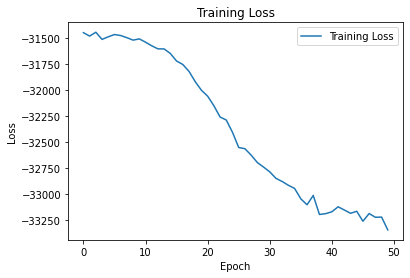

Validation Recall at 150: 0.003091060749331682


In [ ]:
# Initial Parameters
q = 3 # return parameter
p = 5 # in-out parameter
walk_length = 5 # walk length
k = 20 # for negative sampling
d = 10 # Embedding size
max_norm = 0.5 # for embedding
num_epochs = 50
learningRate = 0.01

# Training Results
embedding_node2vec, train_loss, train_recallAt150 = train_node2vec(
    q, p, walk_length, num_epochs, k, learningRate, max_norm, n_users, n_movies, d, adjacency_mat_train, train_probs)

# Validation Results
valid_recallAt150 = recallAtK(k=150, embedding=embedding_node2vec, Adj_mat=adjacency_mat_valid, n_users=n_users, n_movies=n_movies)
print("Validation Recall at 150:", valid_recallAt150)

#### Trial 2

Epoch 0001  Training Loss -31448.2207  Training Recall@150 0.0150
Epoch 0002  Training Loss -31470.5547  Training Recall@150 0.0157
Epoch 0003  Training Loss -31479.5625  Training Recall@150 0.0161
Epoch 0004  Training Loss -31470.7129  Training Recall@150 0.0169
Epoch 0005  Training Loss -31457.9473  Training Recall@150 0.0158
Epoch 0006  Training Loss -31471.8496  Training Recall@150 0.0130
Epoch 0007  Training Loss -31497.3848  Training Recall@150 0.0122
Epoch 0008  Training Loss -31513.5039  Training Recall@150 0.0145
Epoch 0009  Training Loss -31531.4766  Training Recall@150 0.0108
Epoch 0010  Training Loss -31540.9766  Training Recall@150 0.0109
Epoch 0011  Training Loss -31510.0176  Training Recall@150 0.0129
Epoch 0012  Training Loss -31567.4492  Training Recall@150 0.0143
Epoch 0013  Training Loss -31632.3047  Training Recall@150 0.0123
Epoch 0014  Training Loss -31686.1172  Training Recall@150 0.0118
Epoch 0015  Training Loss -31728.1953  Training Recall@150 0.0126
Epoch 0016

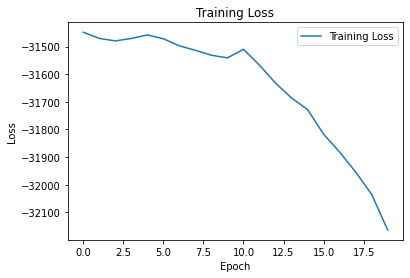

Validation Recall at 150: 0.016388386332661965


In [ ]:
# Initial Parameters
q = 3 # return parameter
p = 5 # in-out parameter
walk_length = 5 # walk length
k = 20 # for negative sampling
d = 10 # Embedding size
max_norm = 0.5 # for embedding
num_epochs = 20
learningRate = 0.01

# Training Results
embedding_node2vec, train_loss, train_recallAt150 = train_node2vec(
    q, p, walk_length, num_epochs, k, learningRate, max_norm, n_users, n_movies, d, adjacency_mat_train, train_probs)

# Validation Results
valid_recallAt150 = recallAtK(k=150, embedding=embedding_node2vec, Adj_mat=adjacency_mat_valid, n_users=n_users, n_movies=n_movies)
print("Validation Recall at 150:", valid_recallAt150)

#### Trial 3

Epoch 0001  Training Loss -31476.4590  Training Recall@150 0.0179
Epoch 0002  Training Loss -31452.3828  Training Recall@150 0.0192
Epoch 0003  Training Loss -31469.7793  Training Recall@150 0.0189
Epoch 0004  Training Loss -31475.2598  Training Recall@150 0.0161
Epoch 0005  Training Loss -31458.3203  Training Recall@150 0.0156
Epoch 0006  Training Loss -31472.0762  Training Recall@150 0.0153
Epoch 0007  Training Loss -31487.6113  Training Recall@150 0.0167
Epoch 0008  Training Loss -31522.0859  Training Recall@150 0.0146
Epoch 0009  Training Loss -31572.9453  Training Recall@150 0.0129
Epoch 0010  Training Loss -31605.0098  Training Recall@150 0.0117
Epoch 0011  Training Loss -31713.9434  Training Recall@150 0.0128
Epoch 0012  Training Loss -31863.3223  Training Recall@150 0.0119
Epoch 0013  Training Loss -31958.0781  Training Recall@150 0.0122
Epoch 0014  Training Loss -32155.0195  Training Recall@150 0.0104
Epoch 0015  Training Loss -32263.7012  Training Recall@150 0.0114
Epoch 0016

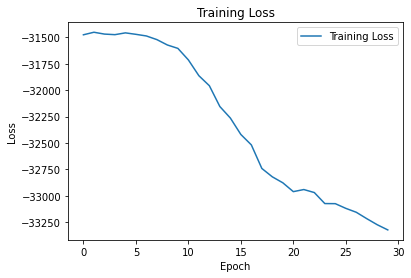

Validation Recall at 150: 0.022033181118507026


In [ ]:
# Parameters
q = 2 # return parameter
p = 5 # in-out parameter
walk_length = 5 # walk length
k = 20 # for negative sampling
d = 10 # Embedding size
max_norm = 0.5 # for embedding
num_epochs = 30
learningRate = 0.02

# Training Results
embedding_node2vec, train_loss, train_recallAt150 = train_node2vec(
    q, p, walk_length, num_epochs, k, learningRate, max_norm, n_users, n_movies, d, adjacency_mat_train, train_probs)

# Validation Results
valid_recallAt150 = recallAtK(k=150, embedding=embedding_node2vec, Adj_mat=adjacency_mat_valid, n_users=n_users, n_movies=n_movies)
print("Validation Recall at 150:", valid_recallAt150)

#### Trial 4

Epoch 0001  Training Loss -18858.4414  Training Recall@150 0.0156
Epoch 0002  Training Loss -18860.9258  Training Recall@150 0.0151
Epoch 0003  Training Loss -18853.9531  Training Recall@150 0.0163
Epoch 0004  Training Loss -18875.8340  Training Recall@150 0.0165
Epoch 0005  Training Loss -18867.0742  Training Recall@150 0.0181
Epoch 0006  Training Loss -18864.4219  Training Recall@150 0.0145
Epoch 0007  Training Loss -18864.1191  Training Recall@150 0.0155
Epoch 0008  Training Loss -18885.6328  Training Recall@150 0.0148
Epoch 0009  Training Loss -18866.2676  Training Recall@150 0.0141
Epoch 0010  Training Loss -18895.9082  Training Recall@150 0.0156
Epoch 0011  Training Loss -18914.2402  Training Recall@150 0.0141
Epoch 0012  Training Loss -18900.0703  Training Recall@150 0.0127
Epoch 0013  Training Loss -18933.3340  Training Recall@150 0.0127
Epoch 0014  Training Loss -18949.6953  Training Recall@150 0.0130
Epoch 0015  Training Loss -18973.5742  Training Recall@150 0.0133
Epoch 0016

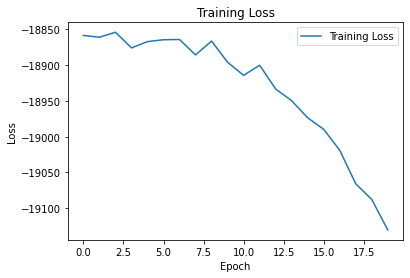

Validation Recall at 150: 0.011957451965293688


In [ ]:
# Parameters
q = 1 # return parameter
p = 1 # in-out parameter
walk_length = 3 # walk length
k = 20 # for negative sampling
d = 10 # Embedding size
max_norm = 0.4 # for embedding
num_epochs = 20
learningRate = 0.02

# Training Results
embedding_node2vec, train_loss, train_recallAt150 = train_node2vec(
    q, p, walk_length, num_epochs, k, learningRate, max_norm, n_users, n_movies, d, adjacency_mat_train, train_probs)

# Validation Results
valid_recallAt150 = recallAtK(k=150, embedding=embedding_node2vec, Adj_mat=adjacency_mat_valid, n_users=n_users, n_movies=n_movies)
print("Validation Recall at 150:", valid_recallAt150)

#### Trial 5

Epoch 0001  Training Loss -64491.5859  Training Recall@150 0.0132
Epoch 0002  Training Loss -64498.9180  Training Recall@150 0.0153
Epoch 0003  Training Loss -64501.5273  Training Recall@150 0.0141
Epoch 0004  Training Loss -64505.7344  Training Recall@150 0.0133
Epoch 0005  Training Loss -64498.2148  Training Recall@150 0.0139
Epoch 0006  Training Loss -64514.6758  Training Recall@150 0.0142
Epoch 0007  Training Loss -64519.9688  Training Recall@150 0.0144
Epoch 0008  Training Loss -64559.3828  Training Recall@150 0.0132
Epoch 0009  Training Loss -64600.4453  Training Recall@150 0.0124
Epoch 0010  Training Loss -64662.0703  Training Recall@150 0.0122
Epoch 0011  Training Loss -64772.7031  Training Recall@150 0.0121
Epoch 0012  Training Loss -64837.9570  Training Recall@150 0.0127
Epoch 0013  Training Loss -64975.7500  Training Recall@150 0.0121
Epoch 0014  Training Loss -65037.0547  Training Recall@150 0.0122
Epoch 0015  Training Loss -65179.8672  Training Recall@150 0.0120
Epoch 0016

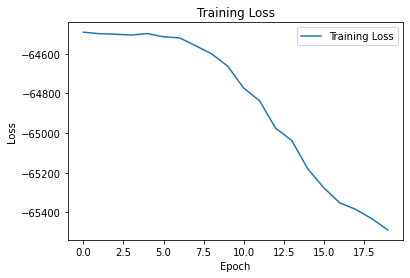

Validation Recall at 150: 0.01984595542327023


In [ ]:
# Parameters
q = 1 # return parameter
p = 1 # in-out parameter
walk_length = 5 # walk length
k = 40 # for negative sampling
d = 10 # Embedding size
max_norm = 0.3 # for embedding
num_epochs = 20
learningRate = 0.01

# Training Results
embedding_node2vec, train_loss, train_recallAt150 = train_node2vec(
    q, p, walk_length, num_epochs, k, learningRate, max_norm, n_users, n_movies, d, adjacency_mat_train, train_probs)

# Validation Results
valid_recallAt150 = recallAtK(k=150, embedding=embedding_node2vec, Adj_mat=adjacency_mat_valid, n_users=n_users, n_movies=n_movies)
print("Validation Recall at 150:", valid_recallAt150)

#### Trial 6

Epoch 0001  Training Loss -8941.0479  Training Recall@150 0.0142
Epoch 0002  Training Loss -8937.4678  Training Recall@150 0.0152
Epoch 0003  Training Loss -8943.1562  Training Recall@150 0.0123
Epoch 0004  Training Loss -8939.9609  Training Recall@150 0.0145
Epoch 0005  Training Loss -8946.2666  Training Recall@150 0.0157
Epoch 0006  Training Loss -8948.8779  Training Recall@150 0.0154
Epoch 0007  Training Loss -8946.6592  Training Recall@150 0.0142
Epoch 0008  Training Loss -8938.0000  Training Recall@150 0.0149
Epoch 0009  Training Loss -8944.6719  Training Recall@150 0.0167
Epoch 0010  Training Loss -8956.0439  Training Recall@150 0.0159
Epoch 0011  Training Loss -8960.1680  Training Recall@150 0.0180
Epoch 0012  Training Loss -8956.7666  Training Recall@150 0.0178
Epoch 0013  Training Loss -8953.5889  Training Recall@150 0.0156
Epoch 0014  Training Loss -8965.5146  Training Recall@150 0.0158
Epoch 0015  Training Loss -8970.3711  Training Recall@150 0.0184
Epoch 0016  Training Loss

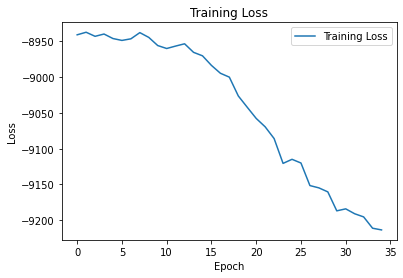

Validation Recall at 150: 0.0074002536091613514


In [ ]:
# Parameters
q = 2 # return parameter
p = 3 # in-out parameter
walk_length = 3 # walk length
k = 10 # for negative sampling
d = 10 # Embedding size
max_norm = 0.4 # for embedding
num_epochs = 35
learningRate = 0.05

# Training Results
embedding_node2vec, train_loss, train_recallAt150 = train_node2vec(
    q, p, walk_length, num_epochs, k, learningRate, max_norm, n_users, n_movies, d, adjacency_mat_train, train_probs)

# Validation Results
valid_recallAt150 = recallAtK(k=150, embedding=embedding_node2vec, Adj_mat=adjacency_mat_valid, n_users=n_users, n_movies=n_movies)
print("Validation Recall at 150:", valid_recallAt150)

#### Trial 7

Epoch 0001  Training Loss -8941.6133  Training Recall@150 0.0170
Epoch 0002  Training Loss -8943.0244  Training Recall@150 0.0149
Epoch 0003  Training Loss -8942.6816  Training Recall@150 0.0138
Epoch 0004  Training Loss -8949.2129  Training Recall@150 0.0151
Epoch 0005  Training Loss -8940.6357  Training Recall@150 0.0152
Epoch 0006  Training Loss -8948.6104  Training Recall@150 0.0153
Epoch 0007  Training Loss -8943.2549  Training Recall@150 0.0142
Epoch 0008  Training Loss -8961.0518  Training Recall@150 0.0150
Epoch 0009  Training Loss -8968.4326  Training Recall@150 0.0148
Epoch 0010  Training Loss -8976.2109  Training Recall@150 0.0130
Epoch 0011  Training Loss -8977.5928  Training Recall@150 0.0141
Epoch 0012  Training Loss -8992.9600  Training Recall@150 0.0155
Epoch 0013  Training Loss -9001.6641  Training Recall@150 0.0165
Epoch 0014  Training Loss -9011.7861  Training Recall@150 0.0161
Epoch 0015  Training Loss -9038.9736  Training Recall@150 0.0126
Epoch 0016  Training Loss

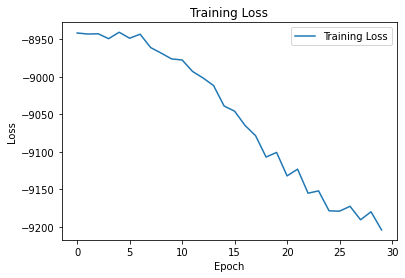

Validation Recall at 150: 0.022238220576897023


In [ ]:
# Parameters
q = 2 # return parameter
p = 3 # in-out parameter
walk_length = 3 # walk length
k = 10 # for negative sampling
d = 10 # Embedding size
max_norm = 0.4 # for embedding
num_epochs = 30
learningRate = 0.05

# Training Results
embedding_node2vec, train_loss, train_recallAt150 = train_node2vec(
    q, p, walk_length, num_epochs, k, learningRate, max_norm, n_users, n_movies, d, adjacency_mat_train, train_probs)

# Validation Results
valid_recallAt150 = recallAtK(k=150, embedding=embedding_node2vec, Adj_mat=adjacency_mat_valid, n_users=n_users, n_movies=n_movies)
print("Validation Recall at 150:", valid_recallAt150)

#### Trial 8

Epoch 0001  Training Loss -48607.7656  Training Recall@150 0.0116
Epoch 0002  Training Loss -48635.0898  Training Recall@150 0.0127
Epoch 0003  Training Loss -48622.3281  Training Recall@150 0.0127
Epoch 0004  Training Loss -48632.5781  Training Recall@150 0.0129
Epoch 0005  Training Loss -48646.1445  Training Recall@150 0.0124
Epoch 0006  Training Loss -48644.6094  Training Recall@150 0.0121
Epoch 0007  Training Loss -48639.6211  Training Recall@150 0.0126
Epoch 0008  Training Loss -48674.1875  Training Recall@150 0.0136
Epoch 0009  Training Loss -48675.1328  Training Recall@150 0.0140
Epoch 0010  Training Loss -48702.8828  Training Recall@150 0.0137
Epoch 0011  Training Loss -48776.3789  Training Recall@150 0.0132
Epoch 0012  Training Loss -48818.9258  Training Recall@150 0.0131
Epoch 0013  Training Loss -48901.8633  Training Recall@150 0.0119
Epoch 0014  Training Loss -48976.0195  Training Recall@150 0.0139
Epoch 0015  Training Loss -49114.2070  Training Recall@150 0.0163


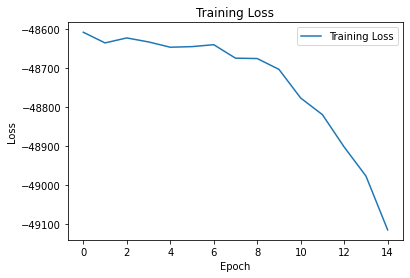

Validation Recall at 150: 0.009437643809599355


In [ ]:
# Parameters
q = 2 # return parameter
p = 3 # in-out parameter
walk_length = 3 # walk length
k = 50 # for negative sampling
d = 10 # Embedding size
max_norm = 0.4 # for embedding
num_epochs = 15
learningRate = 0.01

# Training Results
embedding_node2vec, train_loss, train_recallAt150 = train_node2vec(
    q, p, walk_length, num_epochs, k, learningRate, max_norm, n_users, n_movies, d, adjacency_mat_train, train_probs)

# Validation Results
valid_recallAt150 = recallAtK(k=150, embedding=embedding_node2vec, Adj_mat=adjacency_mat_valid, n_users=n_users, n_movies=n_movies)
print("Validation Recall at 150:", valid_recallAt150)

#### Trial 9

Epoch 0001  Training Loss -23167.9824  Training Recall@150 0.0173
Epoch 0002  Training Loss -23150.4082  Training Recall@150 0.0187
Epoch 0003  Training Loss -23166.6543  Training Recall@150 0.0183
Epoch 0004  Training Loss -23163.5020  Training Recall@150 0.0173
Epoch 0005  Training Loss -23186.5410  Training Recall@150 0.0171
Epoch 0006  Training Loss -23176.1484  Training Recall@150 0.0169
Epoch 0007  Training Loss -23182.4648  Training Recall@150 0.0156
Epoch 0008  Training Loss -23204.8633  Training Recall@150 0.0153
Epoch 0009  Training Loss -23221.6055  Training Recall@150 0.0154
Epoch 0010  Training Loss -23223.5820  Training Recall@150 0.0171
Epoch 0011  Training Loss -23246.9902  Training Recall@150 0.0163
Epoch 0012  Training Loss -23308.2617  Training Recall@150 0.0165
Epoch 0013  Training Loss -23330.4336  Training Recall@150 0.0171
Epoch 0014  Training Loss -23372.1172  Training Recall@150 0.0174
Epoch 0015  Training Loss -23431.9746  Training Recall@150 0.0169


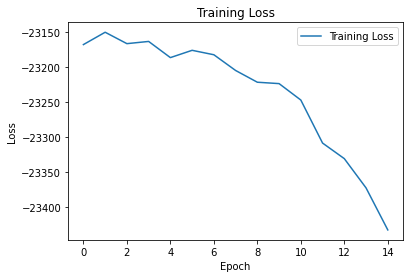

Validation Recall at 150: 0.014858142069459731


In [ ]:
# Parameters
q = 2 # return parameter
p = 3 # in-out parameter
walk_length = 5 # walk length
k = 15 # for negative sampling
d = 10 # Embedding size
max_norm = 0.4 # for embedding
num_epochs = 15
learningRate = 0.02

# Training Results
embedding_node2vec, train_loss, train_recallAt150 = train_node2vec(
    q, p, walk_length, num_epochs, k, learningRate, max_norm, n_users, n_movies, d, adjacency_mat_train, train_probs)

# Validation Results
valid_recallAt150 = recallAtK(k=150, embedding=embedding_node2vec, Adj_mat=adjacency_mat_valid, n_users=n_users, n_movies=n_movies)
print("Validation Recall at 150:", valid_recallAt150)

#### Trial 10

Epoch 0001  Training Loss -38693.9141  Training Recall@150 0.0132
Epoch 0002  Training Loss -38713.7422  Training Recall@150 0.0143
Epoch 0003  Training Loss -38716.4023  Training Recall@150 0.0171
Epoch 0004  Training Loss -38719.7383  Training Recall@150 0.0140
Epoch 0005  Training Loss -38712.7148  Training Recall@150 0.0161
Epoch 0006  Training Loss -38717.5703  Training Recall@150 0.0162
Epoch 0007  Training Loss -38721.2656  Training Recall@150 0.0164
Epoch 0008  Training Loss -38739.5898  Training Recall@150 0.0150
Epoch 0009  Training Loss -38739.3867  Training Recall@150 0.0161
Epoch 0010  Training Loss -38763.2070  Training Recall@150 0.0154
Epoch 0011  Training Loss -38767.2266  Training Recall@150 0.0149
Epoch 0012  Training Loss -38795.7383  Training Recall@150 0.0149
Epoch 0013  Training Loss -38833.7695  Training Recall@150 0.0147
Epoch 0014  Training Loss -38853.3242  Training Recall@150 0.0134
Epoch 0015  Training Loss -38912.9180  Training Recall@150 0.0126
Epoch 0016

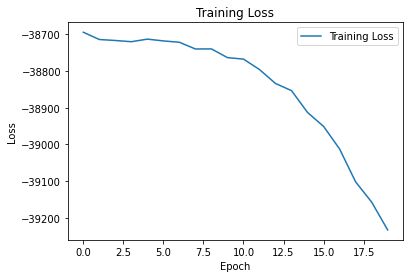

Validation Recall at 150: 0.024514964318910624


In [ ]:
# Parameters
q = 1 # return parameter
p = 1 # in-out parameter
walk_length = 3 # walk length
k = 40 # for negative sampling
d = 10 # Embedding size
max_norm = 0.4 # for embedding
num_epochs = 20
learningRate = 0.01

# Training Results
embedding_node2vec, train_loss, train_recallAt150 = train_node2vec(
    q, p, walk_length, num_epochs, k, learningRate, max_norm, n_users, n_movies, d, adjacency_mat_train, train_probs)

# Validation Results
valid_recallAt150 = recallAtK(k=150, embedding=embedding_node2vec, Adj_mat=adjacency_mat_valid, n_users=n_users, n_movies=n_movies)
print("Validation Recall at 150:", valid_recallAt150)

#### Trial 11

Epoch 0001  Training Loss -38702.3086  Training Recall@150 0.0154
Epoch 0002  Training Loss -38713.6250  Training Recall@150 0.0137
Epoch 0003  Training Loss -38716.3789  Training Recall@150 0.0172
Epoch 0004  Training Loss -38720.8047  Training Recall@150 0.0145
Epoch 0005  Training Loss -38729.0234  Training Recall@150 0.0145
Epoch 0006  Training Loss -38728.0820  Training Recall@150 0.0148
Epoch 0007  Training Loss -38723.5586  Training Recall@150 0.0134
Epoch 0008  Training Loss -38737.5664  Training Recall@150 0.0135
Epoch 0009  Training Loss -38759.8750  Training Recall@150 0.0135
Epoch 0010  Training Loss -38772.5508  Training Recall@150 0.0129
Epoch 0011  Training Loss -38782.1523  Training Recall@150 0.0136
Epoch 0012  Training Loss -38836.2461  Training Recall@150 0.0135
Epoch 0013  Training Loss -38878.4258  Training Recall@150 0.0130
Epoch 0014  Training Loss -38929.4805  Training Recall@150 0.0120
Epoch 0015  Training Loss -38973.3516  Training Recall@150 0.0129
Epoch 0016

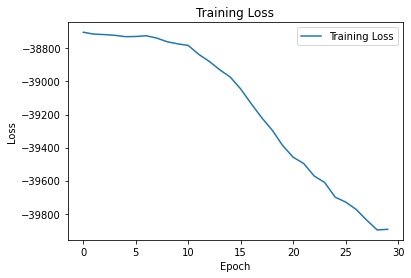

Validation Recall at 150: 0.023097226963291712


In [ ]:
# Parameters
q = 1 # return parameter
p = 1 # in-out parameter
walk_length = 3 # walk length
k = 40 # for negative sampling
d = 10 # Embedding size
max_norm = 0.4 # for embedding
num_epochs = 30
learningRate = 0.01

# Training Results
embedding_node2vec, train_loss, train_recallAt150 = train_node2vec(
    q, p, walk_length, num_epochs, k, learningRate, max_norm, n_users, n_movies, d, adjacency_mat_train, train_probs)

# Validation Results
valid_recallAt150 = recallAtK(k=150, embedding=embedding_node2vec, Adj_mat=adjacency_mat_valid, n_users=n_users, n_movies=n_movies)
print("Validation Recall at 150:", valid_recallAt150)

#### Trial 12

Epoch 0001  Training Loss -38700.4336  Training Recall@150 0.0146
Epoch 0002  Training Loss -38709.4453  Training Recall@150 0.0153
Epoch 0003  Training Loss -38694.1055  Training Recall@150 0.0163
Epoch 0004  Training Loss -38717.2227  Training Recall@150 0.0155
Epoch 0005  Training Loss -38720.7891  Training Recall@150 0.0165
Epoch 0006  Training Loss -38706.1875  Training Recall@150 0.0156
Epoch 0007  Training Loss -38713.9922  Training Recall@150 0.0162
Epoch 0008  Training Loss -38732.3750  Training Recall@150 0.0172
Epoch 0009  Training Loss -38733.3398  Training Recall@150 0.0150
Epoch 0010  Training Loss -38728.0000  Training Recall@150 0.0161
Epoch 0011  Training Loss -38743.8008  Training Recall@150 0.0151
Epoch 0012  Training Loss -38763.5273  Training Recall@150 0.0145
Epoch 0013  Training Loss -38782.9375  Training Recall@150 0.0137
Epoch 0014  Training Loss -38807.7422  Training Recall@150 0.0152
Epoch 0015  Training Loss -38824.3867  Training Recall@150 0.0163
Epoch 0016

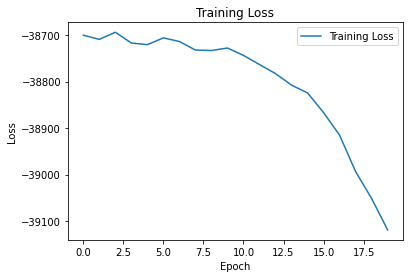

Validation Recall at 150: 0.033185706034864614


In [ ]:
# Parameters
q = 2 # return parameter
p = 3 # in-out parameter
walk_length = 3 # walk length
k = 40 # for negative sampling
d = 10 # Embedding size
max_norm = 0.4 # for embedding
num_epochs = 20
learningRate = 0.01

# Training Results
embedding_node2vec, train_loss, train_recallAt150 = train_node2vec(
    q, p, walk_length, num_epochs, k, learningRate, max_norm, n_users, n_movies, d, adjacency_mat_train, train_probs)

# Validation Results
valid_recallAt150 = recallAtK(k=150, embedding=embedding_node2vec, Adj_mat=adjacency_mat_valid, n_users=n_users, n_movies=n_movies)
print("Validation Recall at 150:", valid_recallAt150)

### Test Results
From the trials above, it was found that embeddings learned in Trial 12 resulted the highest Recall@150 on the validation set with the following hyperparameters:
* q (return parameter) = 2 
* p (in-out parameter) = 3 
* Random walk length = 3 
* k (number of negatively sampled nodes) = 40 
* d (size of embedding for each node) = 10 
* Max norm of embedding = 0.4 
* Number of epochs = 20
* Learning rate = 0.01

This embedding was then tested with the test set and achieved a Recall@150 of 3.32% which is an improvement from the 0.31% Recall@150 seen on the validation set initially in the first trial.

In [ ]:
# Test Results
recallAt150 = recallAtK(k=150, embedding=embedding_node2vec, Adj_mat=adjacency_mat_test, n_users=n_users, n_movies=n_movies)
print("Testing Recall at 150:", recallAt150)

Testing Recall at 150: 0.033185706034864614
